# 22 - Machine Learning Débiaisé/Orthogonal

Le prochain méta-apprenant que nous allons examiner est en réalité apparu avant même qu'on les appelle méta-apprenants. Autant que je puisse en juger, il provient d'un article remarquable de 2016 qui a donné naissance à un champ fructueux dans la littérature sur l'inférence causale. L'article s'intitulait *Double Machine Learning for Treatment and Causal Parameters* et il a fallu de nombreuses personnes pour l'écrire : Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo (qui, soit dit en passant, a remporté le prix Nobel d'économie en 2019 avec Abhijit Banerjee et Michael Kremer "pour leur approche expérimentale visant à atténuer la pauvreté mondiale"), Christian Hansen, Whitney Newey et James Robins. Pas étonnant que ce soit un très bon article et j'ai même pris la liberté de représenter ses auteurs comme les Avengers juste parce que (crédit à Paul Goldsmith-Pinkham qui a eu cette idée en premier).

![img](./data/img/debiased-ml/avengers.png)

Il n'y a qu'un seul problème avec cet article : il est incroyablement difficile à lire (ce qui est attendu, puisque c'est un article économétrique). Et comme ce livre a pour objectif de rendre l'inférence causale accessible, nous voici, en train d'essayer de rendre le Machine Learning Débiaisé/Orthogonal intuitif.

Mais qu'est-ce qui le rend si spécial au point de mériter son propre chapitre, en plus des autres méta-apprenants ? Ce qui a attiré mon attention, c'est à quel point ce Machine Learning Débiaisé/Orthogonal est bien justifié. Les autres méthodes que nous avons vues jusqu'à présent, le T-learner, le S-learner et le X-learner, semblent toutes un peu bricolées. Nous pouvons donner une explication intuitive sur pourquoi elles fonctionnent, mais elles ne semblaient pas très générales. En revanche, avec le Machine Learning Débiaisé/Orthogonal, nous avons un cadre général que nous pouvons appliquer, à la fois très intuitif et également très rigoureux. Un autre avantage est que le Machine Learning Débiaisé/Orthogonal fonctionne pour les traitements continus et discrets, ce que ni le T, ni le X-learner ne pouvaient faire. Sans parler du fait que les articles qui le décrivent font un travail incroyable avec l'analyse asymptotique de cet estimateur. Alors sans plus tarder, passons à la pratique.

Encore une fois, comme exemple motivant, nous allons utiliser notre ensemble de données sur les ventes de glace. Pour rappel, ici nous essayons de trouver l'hétérogénéité de l'effet du prix sur les ventes. Notre ensemble de test a des prix assignés de manière aléatoire, mais nos données d'entraînement ne contiennent que des prix observationnels, qui sont potentiellement biaisés.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [2]:
test = pd.read_csv("./data/ice_cream_sales_rnd.csv")
train = pd.read_csv("./data/ice_cream_sales.csv")
train.head()

,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<AxesSubplot:xlabel='price', ylabel='sales'>

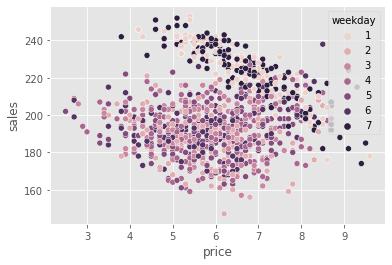

In [3]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

Une source de biais est très claire. Comme nous pouvons le voir, les prix sont beaucoup plus élevés le week-end (jours de la semaine 1 et 7), mais nous pouvons également avoir d'autres variables confondantes, comme la température et le coût. Donc, si nous voulons faire une quelconque inférence causale avec ces données, nous devrons corriger ce biais.

## ML pour les Paramètres de Nuisance

Une façon d'essayer de supprimer ce biais est d'utiliser un modèle linéaire pour estimer l'effet du traitement des prix sur les ventes tout en contrôlant les variables confondantes.

$$
Ventes_i = \alpha + \tau prix_i + \beta_1 temp_i + \beta_2 coût_i + \pmb{\beta_3} JourSemaine_i + e_i
$$

où $\pmb{\beta_3}$ est un vecteur de paramètres associé à chaque indicateur de jour de la semaine.

Remarquez que nous ne sommes intéressés que par le paramètre $\tau$ car c'est notre effet de traitement. Nous allons appeler les autres paramètres des paramètres de nuisance car ils ne nous intéressent pas. Mais, il s'avère que même si nous ne nous en soucions pas, nous devons les estimer correctement, car sinon, notre effet de traitement sera faussé. C'est un peu agaçant.

Par exemple, si on y pense, la relation entre la `température` et les ventes n'est probablement pas linéaire. Tout d'abord, à mesure que la température augmente, plus de gens iront à la plage et achèteront des glaces, donc les ventes augmenteront. Mais, à un certain point, il fera trop chaud et les gens décideront qu'il est préférable de rester chez eux. À ce moment-là, les ventes chuteront. La relation entre la `température` et les ventes atteint probablement un pic avant de diminuer. Ce qui signifie que le modèle ci-dessus est probablement incorrect. Il aurait dû être quelque chose comme

$$
Ventes_i = \alpha + \tau prix_i + \beta_1 temp_i + \beta_2 temp^2_i + \beta_3 coût_i + \pmb{\beta_4} JourSemaine_i + e_i
$$

avec un terme quadratique.

![img](./data/img/debiased-ml/non-linear.png)

Penser à la façon de modéliser les paramètres de nuisance est déjà ennuyeux avec seulement quelques covariables. Mais que faire si nous en avions des dizaines ou des centaines ? Avec les ensembles de données modernes, c'est assez courant. Alors, que pouvons-nous faire à ce sujet ? La réponse réside dans le théorème économétrique le plus cool jamais dérivé.

### Frisch-Waugh-Lovell

Frisch, Waugh et Lovell étaient des économétriciens du 20ème siècle qui ont remarqué la chose la plus cool à propos de la régression linéaire. Ce n'est pas nouveau pour vous, car nous en avons parlé dans le contexte des résidus de régression et en parlant des effets fixes. Mais comme ce théorème est essentiel pour comprendre l'Orthogonal-ML, il vaut vraiment la peine de le récapituler.

Supposons que vous ayez un modèle de régression linéaire avec un ensemble de variables $X_1$ et un autre ensemble de variables $X_2$. Vous estimez ensuite les paramètres de ce modèle.

$
\hat{Y} = \hat{\beta_1} X_1 + \hat{\beta_2} X_2
$

où $X_1$ et $X_2$ sont des matrices de variables (une colonne par variable et une ligne par observation) et $\hat{\beta_1}$ et $\hat{\beta_2}$ sont des vecteurs de paramètres. Vous pouvez obtenir exactement le même paramètre $\hat{\beta_1}$ en suivant les étapes suivantes :

1. régressez le résultat $y$ sur le deuxième ensemble de variables $\hat{y^*} = \hat{\gamma_1} X_2$
2. régressez le premier ensemble de variables sur le deuxième $\hat{X_1} = \hat{\gamma_2} X_2$
3. obtenez les résidus $\tilde{X}_1 = X_1 - \hat{X_1}$ et $\tilde{y}_1 = y - \hat{y^*}$
4. régressez les résidus du résultat sur les résidus des variables $\tilde{y} = \hat{\beta_1} \tilde{X}_1$

C'est incroyablement cool. Ici, nous avons une représentation générique, mais remarquez qu'un ensemble de variables peut être simplement la variable de traitement. Cela signifie que vous pouvez estimer tous les paramètres de nuisance séparément. D'abord, régressez le résultat sur les variables pour obtenir les résidus du résultat. Ensuite, régressez le traitement sur les variables pour obtenir les résidus du traitement. Enfin, régressez les résidus du résultat sur les résidus des variables. Cela donnera la même estimation que si vous régressez le résultat sur les variables et le traitement en même temps.

Mais ne vous contentez pas de me croire sur parole. Le théorème de FWL est quelque chose que toute personne intéressée par l'inférence causale devrait faire au moins une fois. Dans l'exemple ci-dessous, nous estimons l'effet du traitement en estimant d'abord les effets des covariables sur le résultat (ventes) et le traitement (prix).

In [4]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

Donc, avec les résidus, nous estimons l'ATE du prix sur les ventes.

In [5]:
smf.ols("sales_res~price_res", 
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.96e-13,0.111,-4.49e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


Nous avons estimé l'ATE à -4, ce qui signifie que chaque augmentation d'une unité du prix réduira les ventes de 4 unités.

Maintenant, estimons le même paramètre, mais cette fois, nous inclurons le traitement et les covariables dans le même modèle.

In [6]:
smf.ols("sales~price+temp+C(weekday)+cost", data=train).fit().params["price"]

-4.000429145475454

Comme vous pouvez le voir, ils donnent exactement le même résultat ! Cela montre qu'estimer l'effet du traitement d'un coup ou en séparant les étapes selon le théorème FWL est mathématiquement équivalent.

Une autre façon de le dire est que l'effet du traitement peut être dérivé de la **régression sur les résidus**, où nous obtenons les résidus en régressant $Y$ sur $X$ et en le régressant ensuite sur les résidus de la régression de $T$ sur $X$. Supposons que $\sim$ soit l'opérateur de régression, nous pouvons donc résumer le théorème de FWL comme suit.

$
(Y - (Y \sim X)) \sim (T - (T \sim X))
$

ce qui revient essentiellement à estimer le paramètre causal $\tau$ dans le modèle suivant

$
Y_i - E[Y_i | X_i]
= \tau \cdot (T_i - E[T_i | X_i]) + \epsilon
$

Comme je l'ai dit, FWL est incroyable car il permet de séparer la procédure d'estimation du paramètre causal de celle des paramètres de nuisance. Mais nous n'avons toujours pas répondu à notre question initiale, qui est de savoir comment éviter tout le tracas de devoir spécifier la forme fonctionnelle correcte des paramètres de nuisance ? Ou, en d'autres termes, comment se concentrer uniquement sur le paramètre causal sans avoir à se soucier des paramètres de nuisance ? C'est ici que le ML entre en jeu.

![img](./data/img/debiased-ml/drown-ols.png)

### Frisch-Waugh-Lovell sur Stéroïdes

Le ML Double/Debiaisé peut être considéré comme le théorème de Frisch, Waugh et Lovell sur stéroïdes. L'idée est très simple : utiliser des modèles de ML lors de la construction des résidus du résultat et du traitement :

$
Y_i - \hat{M}_y(X_i)
= \tau \cdot (T_i - \hat{M}_t(X_i)) + \epsilon
$

Où $\hat{M}_y(X_i)$ estime $E[Y|X]$ et  $\hat{M}_t(X_i)$ estime $E[T|X]$.

L'idée est que les modèles de ML sont très flexibles, ils peuvent donc capturer des interactions et des non-linéarités lors de l'estimation des résidus de $Y$ et $T$, tout en maintenant une orthogonalisation à la FWL. Cela signifie que nous n'avons pas besoin de faire d'hypothèse paramétrique sur la relation entre les covariables $X$ et le résultat $Y$, ni entre les covariables et le traitement pour obtenir l'effet de traitement correct. À condition de ne pas avoir de variables confondantes non observées, nous pouvons récupérer l'ATE avec la procédure d'orthogonalisation suivante :

1. Estimer le résultat $Y$ avec les covariables $X$ en utilisant un modèle de régression flexible de ML $M_y$.
2. Estimer le traitement $T$ avec les covariables $X$ en utilisant un modèle de régression flexible de ML $M_t$.
3. Obtenir les résidus $\tilde{Y} = Y - M_y(X)$ et $\tilde{T} = T - M_t(X)$.
4. Régresser les résidus du résultat sur les résidus du traitement $\tilde{Y} = \alpha + \tau \tilde{T}$,

où $\tau$ est le paramètre causal ATE, que nous pouvons estimer, par exemple, avec OLS.

La puissance que vous gagnez avec le ML est la flexibilité. Le ML est tellement puissant qu'il peut capturer des formes fonctionnelles complexes dans les relations de nuisance. Mais cette flexibilité pose également problème, car cela signifie que nous devons maintenant prendre en compte la possibilité de surapprentissage (overfitting).

![img](./data/img/debiased-ml/ml-problem.png)

Chernozhukov et al. (2016) donnent une explication beaucoup plus approfondie et rigoureuse sur la manière dont le surapprentissage peut poser problème, et je vous recommande vivement de consulter cet article. Mais ici, je vais continuer avec une explication plus intuitive.

Pour voir le problème, supposons que votre modèle $M_y$ surapprend. Le résultat est que le résidu $\tilde{Y}$ sera plus petit qu'il ne devrait l'être. Cela signifie également que $M_y$ capture plus que la simple relation entre $X$ et $Y$. Une partie de ce "quelque chose de plus" est la relation entre $T$ et $Y$, et si $M_y$ capture une partie de cela, la régression des résidus sera biaisée vers zéro. En d'autres termes, $M_y$ capture la relation causale et ne la laisse pas à la régression des résidus finale.

Pour voir le problème du surapprentissage de $M_t$, remarquez qu'il expliquera plus de variance dans $T$ qu'il ne devrait. En conséquence, le résidu du traitement aura moins de variance qu'il ne devrait. S'il y a moins de variance dans le traitement, la variance de l'estimateur final sera élevée. C'est comme si le traitement était le même pour presque tout le monde. Et si tout le monde a le même niveau de traitement, il devient très difficile d'estimer ce qui se passerait sous différents niveaux de traitement. En passant, cela se produira également lorsque $T$ est une fonction déterministe de $X$, ce qui signifie que la positivité est violée.

Ce sont les problèmes que nous rencontrons avec les modèles de ML, mais comment pouvons-nous les corriger ? La réponse réside dans ce que nous appellerons la prédiction croisée et les résidus hors pli (out-of-fold residuals).

![img](./data/img/debiased-ml/cross-prediction.png)

Nous allons diviser nos données en K parties de taille égale. Ensuite, pour chaque partie k, nous estimerons les modèles de ML sur les K-1 autres échantillons et ferons les résidus sur la partie k. Remarquez que ces résidus sont faits en utilisant des prédictions hors pli. Nous ajustons le modèle sur une partie des données, mais faisons les prédictions et les résidus sur une autre partie.

Ainsi, même si le modèle surapprend, il ne conduira pas artificiellement les résidus à zéro. Enfin, nous combinons les prédictions sur toutes les K parties pour estimer le modèle causal final $\tilde{Y} = \alpha + \tau \tilde{T}$.

D'accord, nous avons couvert beaucoup de terrain, et il peut devenir difficile de suivre sans un exemple. Pour accompagner toute cette théorie, passons à une mise en œuvre étape par étape du Double/Debiased ML. Ce faisant, je prendrai l'occasion d'expliquer ce que fait chaque étape.

Tout d'abord, estimons la relation de nuisance en utilisant des modèles de ML. Je vais commencer par le modèle de traitement $M_t$. Nous utiliserons un modèle LGBM pour prédire les prix à partir des covariables `temp`, `weekday` et `cost`. Ces prédictions seront des prédictions croisées, que nous pouvons obtenir en utilisant la fonction `cross_val_predict` de `sklearn`. J'ajoute également la moyenne $\hat{\mu_t}$ aux résidus juste pour des raisons de visualisation.

In [7]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization. 

Remarquez que j'appelle le modèle $M_t$ le modèle de débiaisage. C'est parce que le rôle de ce modèle dans le ML Double/Debiaisé est de débiaiser le traitement. Les résidus $\tilde{T} = T - M_t(X)$ peuvent être considérés comme une version du traitement où tous les biais de confusion provenant de $X$ ont été éliminés par le modèle. En d'autres termes, $\tilde{T}$ est orthogonal à $X$. Intuitivement, $\tilde{T}$ ne peut plus être expliqué par $X$, car il l'a déjà été.

Pour voir cela, nous pouvons montrer le même graphique que nous avons vu plus tôt, mais cette fois en remplaçant le prix par les résidus de prix. Rappelez-vous qu'auparavant, les prix étaient plus élevés le week-end ? Maintenant, ce biais a disparu. Tous les jours de la semaine ont la même distribution des résidus de prix.

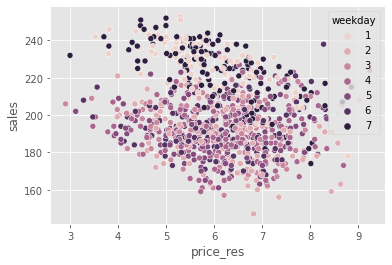

In [8]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

Le rôle de $M_t$ est de débiaiser le traitement, mais qu'en est-il de $M_y$ ? Son rôle est de supprimer la variance de $Y$. Par conséquent, je l'appellerai le modèle de débruitage. Intuitivement, $M_y$ crée une version du résultat où toute la variance due à $X$ a été éliminée. En conséquence, il devient plus facile de faire une estimation causale dans $\tilde{Y}$. Comme il y a moins de bruit, la relation causale devient plus facile à observer.

In [9]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

Si nous traçons le même graphique qu'auparavant, mais en remplaçant les ventes par les résidus de ventes, nous pouvons voir que la variance de $Y$ est beaucoup plus réduite qu'auparavant.

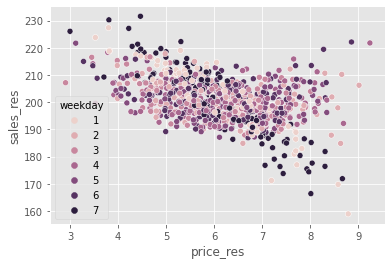

In [10]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

Il est maintenant facile de voir la relation négative entre les prix et les ventes.

Enfin, pour estimer cette relation causale, nous pouvons effectuer une régression sur les résidus.

In [11]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


Comme nous pouvons le voir, lorsque nous utilisons la version résidualisée ou orthogonalisée des ventes et des prix, nous pouvons être très confiants que la relation entre les prix et les ventes est négative, ce qui est tout à fait logique. À mesure que nous augmentons les prix, la demande de glace devrait diminuer.

Mais si nous regardons la relation brute, non résidualisée, entre les prix et les ventes, à cause du biais, nous trouvons une relation positive. Cela s'explique par le fait que, en prévision de fortes ventes, les prix sont augmentés.

In [12]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


### Estimation du CATE avec Double-ML

Jusqu'à présent, nous avons vu comment le ML Double/Debiaisé nous permet de nous concentrer sur l'estimation de l'Effet Moyen du Traitement (ATE), mais il peut également être utilisé pour estimer l'hétérogénéité de l'effet du traitement ou l'Effet Moyen Conditionnel du Traitement (CATE). Essentiellement, nous disons maintenant que le paramètre causal $\tau$ change en fonction des covariables de l'unité.

$$
Y_i - {M}_y(X_i)
= \tau(X_i) \cdot (T_i - {M}_t(X_i)) + \epsilon_i
$$

Pour estimer ce modèle, nous utiliserons la même version résidualisée des prix et des ventes, mais cette fois, nous allons interagir les résidus des prix avec les autres covariables. Ensuite, nous pourrons ajuster un modèle linéaire de CATE.

$$
\tilde{Y_i} = \alpha + \beta_1 \tilde{T_i} + \pmb{\beta}_2 \pmb{X_i} \tilde{T_i} + \epsilon_i
$$

Une fois que nous avons estimé un tel modèle, pour faire des prédictions de CATE, nous utiliserons l'ensemble de test randomisé. Puisque ce modèle final est linéaire, nous pouvons calculer le CATE mécaniquement :

$$
\hat{\mu}(\partial Ventes_i, X_i) = M(Prix=1, X_i) - M(Prix=0, X_i)
$$

où $M$ est notre modèle linéaire final.

In [13]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

Pour vérifier l'efficacité de ce modèle à différencier les unités ayant une forte sensibilité aux prix de celles ayant une faible sensibilité aux prix, nous utiliserons la courbe d'élasticité cumulative.

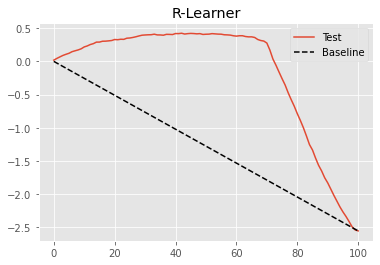

In [14]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

La procédure ML Double/Debiaisé avec un modèle linéaire final est déjà très performante, comme nous pouvons le voir avec la courbe ci-dessus. Mais, peut-être pouvons-nous faire encore mieux. En fait, il s'agit d'une procédure très générale que l'on peut comprendre comme un méta-apprenant. Nie et Wager l'ont appelée le R-Learner, en reconnaissance du travail de Robinson (1988) et pour souligner le rôle de la résidualisation.

Cette généralisation découle de la prise de conscience que la procédure ML Double/Debiaisé définit une nouvelle fonction de perte que nous pouvons minimiser comme bon nous semble. Ensuite, nous verrons comment procéder de manière très similaire à ce que nous avons vu précédemment en discutant de la méthode de transformation cible ou du F-learner.

## ML Double/Debiaisé Non Paramétrique

L'avantage du Double-ML est qu'il nous libère de toutes les complications liées à l'apprentissage des paramètres de nuisance dans un modèle causal. Ainsi, nous pouvons concentrer toute notre attention sur l'apprentissage du paramètre causal d'intérêt, qu'il s'agisse de l'ATE ou du CATE. Cependant, avec la spécification ci-dessus, nous utilisions encore un modèle linéaire après la résidualisation par ML, en tant que modèle causal final. Dans notre exemple, cela signifie que nous supposons que le prix impacte les ventes de manière linéaire. Cela peut être correct pour une petite gamme de prix, mais nous savons, d'après la théorie microéconomique, que ce n'est pas nécessairement le cas. Il se peut que, à des prix bas, une augmentation d'une unité de prix réduise la demande de 2 unités. Mais ensuite, à des prix plus élevés, une augmentation d'une unité de prix réduira la demande de seulement 1 unité. Ce n'est pas une relation linéaire.

Nous pourrions nous appuyer sur la théorie microéconomique pour spéculer sur la forme fonctionnelle du résultat par rapport au traitement, mais nous pouvons aussi déléguer cette tâche à un modèle de ML. En fait, c'est tout à fait possible si nous apportons quelques modifications à notre algorithme de ML Double/Debiaisé ML original.

Tout d'abord, nous commençons exactement comme avant, en orthogonalisant le traitement et le résultat avec des prédictions croisées à partir d'un modèle de ML.

In [15]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5),
                          sales_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5))

Jusqu'à présent, rien de différent. C'est maintenant que les choses deviennent intéressantes. Rappelons que le modèle ML Double/Debiaisé modélise les données comme suit :

$$
Y_i = \hat{M}_y(X_i) + \tau(X_i) \big(T_i - \hat{M}_t(X)\big) + \hat{\epsilon}_i
$$

Où $\hat{M}_y$ et $\hat{M}_t$ sont des modèles qui prédisent respectivement le résultat et le traitement à partir des caractéristiques. Si nous réarrangeons les termes ci-dessus, nous pouvons isoler le terme d'erreur :

$$
\hat{\epsilon}_i = \big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)
$$

C'est tout simplement génial, car maintenant nous pouvons appeler cela une **fonction de perte causale**. Ce qui signifie que, si nous minimisons le carré de cette perte, nous estimerons la valeur attendue de $\tau(X_i)$, qui est le CATE.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg(\big(Y_i - \hat{M}_y(X_i)\big) - \tau(X_i) \big(T_i - \hat{M}_t(X)\big)\bigg)^2
$$

Cette perte est également appelée **R-Loss**, car c'est ce que le R-learner minimise. D'accord, mais comment minimiser cette fonction de perte ? Il existe plusieurs façons de le faire, en réalité, mais ici nous allons couvrir la méthode la plus simple. Tout d'abord, pour simplifier la notation technique, réécrivons la fonction de perte que nous avions auparavant, mais en utilisant la version résidualisée du traitement et du résultat.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1}\bigg( \tilde{Y}_i - \tau(X_i) \tilde{T}_i \bigg)^2
$$

Enfin, nous pouvons faire quelques manipulations algébriques pour sortir $\tilde{T}_i$ des parenthèses et isoler $\tau(X_i)$ dans la partie carrée de la fonction de perte.

$$
\hat{L}_n(\tau(x)) = \frac{1}{n} \sum^n_{i=1} \tilde{T}_i^2 \left(\frac{\tilde{Y}_i}{\tilde{T}_i} - \tau(X_i)\right)^2
$$

Minimiser la perte ci-dessus équivaut à minimiser ce qui est à l'intérieur des parenthèses, tout en pondérant chaque terme par $\tilde{T}_i^2$. Minimiser ce qui est à l'intérieur des parenthèses revient à prédire $\frac{\tilde{Y}_i}{\tilde{T}_i}$. C'est ce qu'on appelle l'astuce de pondération pour obtenir la perte causale non paramétrique. Remarquez à quel point cela est similaire à l'idée de transformation cible que nous avons vue précédemment. C'est, en effet, une transformation cible, mais avec l'astuce de pondération supplémentaire.

Pour résumer avant de passer au code, maintenant que nous avons les modèles de nuisance et les versions résidualisées du traitement et du résultat, nous allons :

1. Créer des poids $\tilde{T}_i^2$
2. Créer une cible $\dfrac{\tilde{Y}_i}{\tilde{T}_i}$
3. Utiliser n'importe quelle méthode de prédiction pour prédire la cible (2) tout en utilisant les poids (1).

Et voici le code. Comme vous le verrez, c'est incroyablement simple.

In [16]:
model_final = LGBMRegressor(max_depth=3)
 
# create the weights
w = train_pred["price_res"] ** 2 
 
# create the transformed target
y_star = (train_pred["sales_res"] / train_pred["price_res"])
 
# use a weighted regression ML model to predict the target with the weights.
model_final.fit(X=train[X], y=y_star, sample_weight=w);

Le modèle de ML ci-dessus, bien qu'il s'agisse d'un modèle prédictif standard, estime le CATE. C'est toute la puissance du ML Double/Debiaisé non paramétrique. Avant, nous utilisions une régression linéaire comme modèle final pour l'estimation du CATE. Maintenant, puisque nous avons défini une fonction de perte générique, nous pouvons utiliser n'importe quel modèle prédictif à notre disposition comme modèle final.

Utilisons maintenant l'ensemble de test pour comparer cette version non paramétrique avec la version linéaire que nous avions auparavant.

Tout d'abord, estimons l'effet individuel du traitement.

In [17]:
cate_test_non_param = test.assign(cate=model_final.predict(test[X]))

Ensuite, nous pouvons tracer la courbe d'élasticité cumulative non paramétrique côte à côte avec celle obtenue à partir de la version paramétrique (linéaire) du ML Double/Orthogonal.

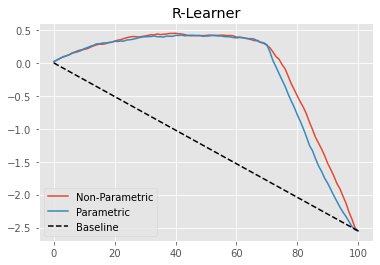

In [18]:
gain_curve_test_non_param = cumulative_gain(cate_test_non_param, "cate", y=y, t=T)
plt.plot(gain_curve_test_non_param, color="C0", label="Non-Parametric")
plt.plot(gain_curve_test, color="C1", label="Parametric")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");

Pas une énorme amélioration ici, mais c'est quelque chose. De plus, ne pas avoir à spécifier la forme fonctionnelle de la fonction de traitement est déjà un avantage considérable.

### Qu'est-ce que cela signifie d'être non paramétrique ?

Avant de continuer, je voulais juste souligner une idée reçue courante. Lorsque nous pensons à utiliser un modèle ML Double/Debiaisé non paramétrique pour estimer le CATE, cela semble indiquer que nous obtiendrons un effet de traitement non linéaire. Par exemple, supposons un processus de génération de données (DGP) très simple où la réduction affecte les ventes de manière non linéaire, mais via une fonction racine carrée.

$$
Sales_i = 20 + 10*\sqrt{Discount_i} + e_i
$$

L'effet de traitement est donné par la dérivée de cette fonction des ventes par rapport au traitement.

$$
\dfrac{\partial Sales_i}{\partial Discount_i} = \dfrac{10}{2\sqrt{Discount_i}}
$$

Comme nous pouvons le voir, l'effet de traitement n'est **pas** linéaire. En fait, il devient plus faible à mesure que le traitement augmente. Cela a beaucoup de sens pour ce DGP. Au départ, un petit rabais augmente beaucoup les ventes. Mais, à mesure que nous accordons trop de rabais, une unité supplémentaire de rabais affectera de moins en moins les ventes, car les gens n'achèteront pas à l'infini. Ainsi, le rabais n'est efficace que jusqu'à un certain point où les clients sont satisfaits.

La question est donc la suivante : le ML non paramétrique peut-il capturer ce comportement de saturation dans l'effet de traitement ? Peut-il extrapoler à partir d'un faible niveau de rabais pour prédire que, si le rabais était plus élevé, l'effet de traitement serait moindre ? La réponse est... en quelque sorte. Pour mieux comprendre cela, générons des données comme dans le DGP ci-dessus.

In [19]:
np.random.seed(321)
n=5000
discount = np.random.gamma(2,10, n).reshape(-1,1)
discount.sort(axis=0) # for better ploting
sales = np.random.normal(20+10*np.sqrt(discount), 1)

Si nous traçons ce DGP, nous pouvons voir la relation racine carrée entre ces variables.

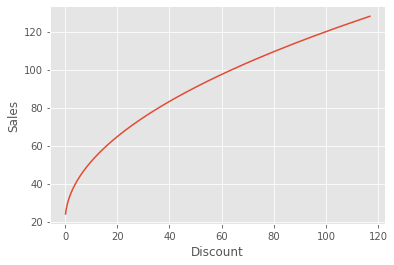

In [20]:
plt.plot(discount, 20 + 10*np.sqrt(discount))
plt.ylabel("Sales")
plt.xlabel("Discount");

Maintenant, appliquons le ML Double/Debiaisé non paramétrique à ces données.

In [21]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# orthogonalising step
discount_res =  discount.ravel() - cross_val_predict(debias_m, np.ones(discount.shape), discount.ravel(), cv=5)
sales_res =  sales.ravel() - cross_val_predict(denoise_m, np.ones(sales.shape), sales.ravel(), cv=5)

# final, non parametric causal model
non_param = LGBMRegressor(max_depth=3)
w = discount_res ** 2 
y_star = sales_res / discount_res

non_param.fit(X=discount_res.reshape(-1,1), y=y_star.ravel(), sample_weight=w.ravel());

Avec le modèle ci-dessus, nous pouvons obtenir l'estimation du CATE. Le problème ici est que le CATE n'est pas linéaire. À mesure que le traitement augmente, le CATE devrait diminuer. La question que nous cherchons à résoudre est de savoir si le modèle non paramétrique peut capturer cette non-linéarité.

Pour bien répondre à cela, rappelons-nous quelle est l'hypothèse sous-jacente que le ML Double/Debiaisé fait sur le processus de génération des données. Ces hypothèses peuvent être observées dans l'équation que nous avons présentée auparavant.

$$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$$

En d'autres termes, cela dit que le résultat résidualisé est égal au traitement résidualisé multiplié par l'effet du traitement conditionnel. Cela signifie que **le traitement impacte le résultat de manière linéaire**. Il n'y a pas de non-linéarité ici. Le modèle ci-dessus dit que le résultat augmentera d'une quantité fixe $\tau(X_i)$ si nous augmentons le traitement de 1 à 10 ou de 100 à 110. C'est une simple multiplication.

Alors, est-ce que cela signifie que le modèle non paramétrique ne peut pas capturer la non-linéarité de l'effet du traitement ? Encore une fois, pas vraiment... En réalité, ce qui se passe, c'est que le ML Double/Debiaisé **trouve l'approximation linéaire locale du CATE non linéaire**. En d'autres termes, il trouve la dérivée du résultat par rapport au traitement à ce niveau de traitement ou autour de celui-ci. C'est équivalent à trouver les pentes des lignes tangentielles à la fonction de résultat au point de traitement.

![img](./data/img/debiased-ml/linear-aprox.png)

Cela signifie que, oui, le ML Double/Debiaisé non paramétrique détectera que l'effet du traitement sera plus faible à mesure que le traitement augmente. Mais, non, il ne trouvera pas l'effet de traitement non linéaire, mais plutôt l'effet de traitement linéaire local. Nous pouvons même tracer ces approximations linéaires par rapport à l'effet causal non linéaire réel, et en effet, elles sont de bonnes approximations.

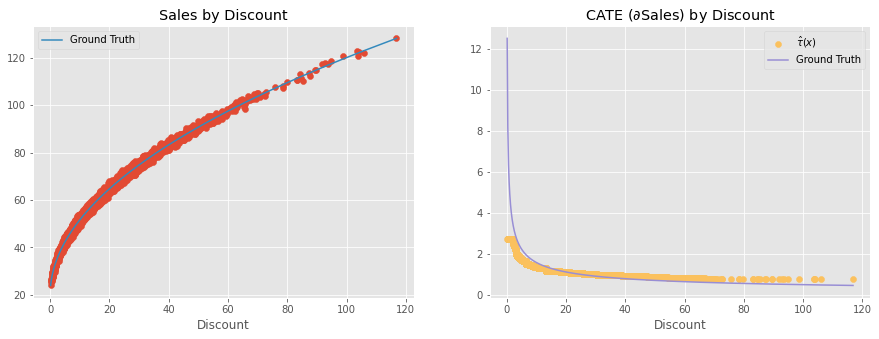

In [22]:
cate = non_param.predict(X=discount)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(discount, sales)
plt.plot(discount, 20 + 10*np.sqrt(discount), label="Ground Truth", c="C1")
plt.title("Sales by Discount")
plt.xlabel("Discount")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(discount, cate, label="$\hat{\\tau}(x)$", c="C4")
plt.plot(discount, 5/np.sqrt(discount), label="Ground Truth", c="C2")
plt.title("CATE ($\partial$Sales) by Discount")
plt.xlabel("Discount")
plt.legend();

Cela peut sembler être des détails techniques, mais cela a des conséquences très pratiques. Par exemple, disons que vous trouvez un effet de traitement de 2 pour un client dans l'exemple ci-dessus, ce qui signifie que si vous augmentez la réduction d'une unité, vos ventes à ce client augmenteront de 2 unités. Vous pourriez voir cela et penser : "Génial ! Je vais accorder beaucoup de réductions à cette unité ! Après tout, pour chaque unité de réduction, j'obtiendrai 2 unités de ventes." Cependant, c'est une mauvaise conclusion. L'effet de traitement est de 2 uniquement à ce niveau de réduction. Dès que vous augmentez la réduction, l'effet diminuera. Par exemple, supposons que ce client hypothétique ait reçu une réduction de seulement 5, c'est pourquoi son effet de traitement est si élevé. Disons que vous voyez cet énorme effet de traitement et que vous l'utilisez pour justifier l'octroi d'une réduction de 20 à ce client. Mais en faisant cela, l'effet pourrait passer de 2 à quelque chose comme 0,5. Et une réduction de 20, qui semblait rentable avec un effet de traitement de 2, pourrait ne plus l'être avec un effet de traitement de 0,5.

Cela signifie que vous devez être très prudent lorsque vous extrapolez un effet de traitement non linéaire à un nouveau niveau de traitement. Si vous ne l'êtes pas, vous risquez de prendre des décisions très peu rentables. Une autre façon de le dire est que, lorsque l'effet de traitement n'est pas linéaire, même le ML Double/Debiaisé non paramétrique aura **du mal à faire des prédictions de résultats contrefactuels**. Il essaiera d'extrapoler linéairement l'effet de traitement (TE) d'un faible niveau de traitement à un niveau de traitement élevé, ou inversement. Et, en raison de la non-linéarité, cette extrapolation sera probablement erronée.

Pour résoudre cela, il existe une idée finale. Gardez à l'esprit que cette idée est bien moins scientifique que ce que nous avons vu jusqu'à présent. Elle se résume à utiliser un S-learner après avoir appliqué la procédure d'orthogonalisation, mais je vais un peu trop vite. Examinons cela ensuite.

![img](./data/img/debiased-ml/non-sci.png)

## ML Double/Debiaisé Non Scientifique

L'idée finale que nous allons essayer repose sur un changement fondamental de mentalité. Nous n'essaierons plus d'estimer l'approximation linéaire du CATE. Au lieu de cela, nous allons faire des prédictions contrefactuelles.

![img](./data/img/debiased-ml/cf-pred.png)

Le CATE est la pente de la fonction de résultat au point de données. C'est combien nous nous attendons à ce que le résultat change si nous augmentons le traitement d'une très petite quantité. Plus techniquement, c'est la dérivée au point. Les prédictions contrefactuelles, en revanche, tentent de recréer toute la courbe du résultat à partir d'un seul point de données. Nous prédirons ce que serait le résultat si le traitement était à un autre niveau que celui qu'il prend actuellement, d'où le terme "contrefactuel".

Si nous y parvenons, nous serons en mesure de simuler différents traitements pour une unité et de prédire comment elle réagirait à ces différents niveaux de traitement. C'est une affaire très risquée, car nous extrapolons une courbe entière à partir d'un seul point. De plus, bien que j'aie utilisé cette technique en pratique à plusieurs reprises, je n'ai jamais trouvé d'article scientifique montrant comment ou pourquoi elle fonctionne. C'est pourquoi je l'appelle le ML Double/Debiaisé non scientifique. En termes simples : soyez prudent !

Voici comment cela va se dérouler. Tout d'abord, commençons par la formulation traditionnelle du ML Double/Debiaisé, où nous avons la version résidualisée du traitement et du résultat.

$$
\tilde{Y}_i = \tau(X_i) \tilde{T}_i + e_i
$$

Maintenant, je vais déplacer le traitement à l'intérieur de la fonction d'effet du traitement. Cela permet à l'effet du traitement d'être non linéaire, c'est-à-dire de changer avec le traitement lui-même.

$$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i) + e_i
$$

C'est une entreprise risquée, car je n'ai aucune idée de la forme de cette fonction de traitement. Pour autant que nous le sachions, il pourrait s'agir d'une fonction non linéaire étrange. Mais heureusement, nous savons comment estimer des fonctions étranges avec le ML. Donc, c'est ce que nous allons faire. En termes simples, nous allons ajuster un modèle de ML pour prédire le résultat résidualisé $\tilde{Y}$ à partir du traitement résidualisé $\tilde{T}$ ainsi que des caractéristiques $X$. La résidualisation est importante pour éliminer les biais et le bruit afin que ce ML final puisse se concentrer sur l'apprentissage uniquement de l'effet de traitement et sur la manière dont les covariables $X$ influencent cet effet de traitement.

Ensuite, une fois que nous avons ce modèle, nous ferons des prédictions contrefactuelles en deux étapes. Tout d'abord, nous devrons faire une prédiction pour le traitement afin d'obtenir $\tilde{T}$, puis, nous utiliserons cette prédiction, ainsi que les caractéristiques, dans notre modèle final $\hat{\tau}(X_i, \tilde{T}_i)$.

Puisque nous devrons faire $\tilde{T}$, nous devons d'abord implémenter notre propre version de la fonction `cross_prediction`. Cette fonction renverra non seulement la prédiction croisée, mais aussi les modèles utilisés pour faire ces prédictions.

In [23]:
from sklearn.model_selection import KFold

def cv_estimate(train_data, n_splits, model, model_params, X, y):
    cv = KFold(n_splits=n_splits)    
    models = []
    cv_pred = pd.Series(np.nan, index=train_data.index)
    for train, test in cv.split(train_data):
        m = model(**model_params)
        m.fit(train_data[X].iloc[train], train_data[y].iloc[train])
        cv_pred.iloc[test] = m.predict(train_data[X].iloc[test])
        models += [m]
    
    return cv_pred, models


Maintenant que nous avons notre propre fonction de prédiction croisée qui nous donne également les modèles, nous pouvons procéder à l'étape d'orthogonalisation.

In [24]:
y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

y_hat, models_y = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, y)
t_hat, models_t = cv_estimate(train, 5, LGBMRegressor, dict(max_depth=3), X, T)

y_res = train[y] - y_hat
t_res = train[T] - t_hat

Après l'orthogonalisation, nous allons introduire $\tilde{T}$ ainsi que $X$ dans un modèle de ML qui essaie de prédire $\tilde{Y}$. J'utilise ici un modèle LGBM, mais vous pouvez choisir n'importe quel modèle de ML. Une chose intéressante à propos de LGBM est que je peux y appliquer des contraintes monotones. Compte tenu de ce que nous savons sur les prix, les ventes devraient diminuer à mesure que les prix augmentent. Nous pouvons en tenir compte et contraindre notre modèle LGBM à **ne pas augmenter** ses prédictions à mesure que les prix augmentent.

In [25]:
# -1 on price saying that the predictions should not increase as price increases
monotone_constraints = [-1 if col == T else 0 for col in X+[T]]
 
model_final = LGBMRegressor(max_depth=3, monotone_constraints=monotone_constraints)
model_final = model_final.fit(X=train[X].assign(**{T: t_res}), y=y_res)

Maintenant, les choses deviennent un peu étranges. Si l'on y réfléchit, ce modèle final de ML estime la fonction de traitement $\tau$ suivante :

$$
\tilde{Y}_i = \tau(X_i, \tilde{T}_i)  + e_i
$$

Mais il n'existe pas de moyen clair d'extraire l'effet de traitement de cette fonction. Donc, plutôt que d'extraire un effet de traitement, nous allons entrer les prédictions contrefactuelles, comme je l'ai montré dans l'image précédente. Nous allons simuler différents niveaux de prix pour chaque unité et utiliser notre modèle ML Double/Debiaisé pour prédire quelles seraient les ventes que nous observerions sous ces différents niveaux de prix.

Pour y parvenir, nous allons 1) faire un *cross join* de l'ensemble de test avec une table de prix contenant tous les prix simulés. Le résultat final sera le suivant :

In [26]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 10, 9))), on="jk")
             .drop(columns=["jk"]))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price
0,0,25.8,1,0.3,7,230,3.000
1,0,25.8,1,0.3,7,230,3.875
2,0,25.8,1,0.3,7,230,4.750
3,0,25.8,1,0.3,7,230,5.625
4,0,25.8,1,0.3,7,230,6.500
5,0,25.8,1,0.3,7,230,7.375
6,0,25.8,1,0.3,7,230,8.250
7,0,25.8,1,0.3,7,230,9.125
8,0,25.8,1,0.3,7,230,10.000


Remarquez que nous montrons uniquement le jour à l'indice 1, donc une seule unité. Ce jour-là (unité), le prix ou traitement réel, ou factuel, était de 7. Mais nous avons simulé différents traitements contrefactuels, de 3 à 10. Maintenant, nous allons entrer tous ces prix contrefactuels dans notre modèle causal, qui fera des prédictions de ventes contrefactuelles basées sur ces prix simulés.

Étant donné que notre modèle a le format suivant :

$$
\widehat{Price_i} = \hat{\tau}(X_i, \tilde{T}_i)
$$

Avant de faire les prédictions contrefactuelles, nous devons obtenir $\tilde{T}_i$, c'est-à-dire les résidus de prix. Pour obtenir ces résidus, nous commencerons par faire des prédictions avec tous nos modèles de traitement (rappelez-vous que nous avons utilisé une prédiction croisée en 5 plis lors de l'étape d'entraînement). Ensuite, nous ferons la moyenne des prédictions des cinq modèles pour obtenir une prédiction unique, et enfin, nous soustrairons le prix contrefactuel que nous avons généré plus tôt du prix prédit en utilisant cet ensemble de modèles.

In [27]:
def ensamble_pred(df, models, X):
    return np.mean([m.predict(df[X]) for m in models], axis=0)

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test}))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,24.302849
1,0,25.8,1,0.3,7,230,3.875,20.862833
2,0,25.8,1,0.3,7,230,4.750,16.093630
3,0,25.8,1,0.3,7,230,5.625,6.274595
4,0,25.8,1,0.3,7,230,6.500,-1.624625
5,0,25.8,1,0.3,7,230,7.375,-10.939867
6,0,25.8,1,0.3,7,230,8.250,-21.655858
7,0,25.8,1,0.3,7,230,9.125,-25.319174
8,0,25.8,1,0.3,7,230,10.000,-25.319174


Comme vous pouvez le voir, nous avons maintenant une prédiction de ventes pour chaque prix simulé. Plus le prix est bas, plus les ventes sont élevées. Une chose intéressante à noter est que ces prédictions sont décalées en termes de niveau. Par exemple, elles varient d'environ 24 à environ -24. Cela s'explique par le fait que le modèle prédit le résultat résidualisé, qui est approximativement centré autour de zéro. Cela est acceptable si tout ce que vous souhaitez obtenir est la pente de la courbe des ventes, qui correspond à l'effet de traitement du prix. De plus, si vous souhaitez ajuster les niveaux de prédiction, il vous suffit d'ajouter les prédictions du modèle de débruitage $M_y$.

In [28]:
y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = (y_hat_test + 
                          model_final.predict(X=pred_test[X].assign(**{T: t_res_test})))

pred_test.query("index==0")

,index,temp,weekday,cost,factual_price,sales,price,sales_pred
0,0,25.8,1,0.3,7,230,3.000,254.208352
1,0,25.8,1,0.3,7,230,3.875,250.768336
2,0,25.8,1,0.3,7,230,4.750,245.999133
3,0,25.8,1,0.3,7,230,5.625,236.180099
4,0,25.8,1,0.3,7,230,6.500,228.280878
5,0,25.8,1,0.3,7,230,7.375,218.965636
6,0,25.8,1,0.3,7,230,8.250,208.249645
7,0,25.8,1,0.3,7,230,9.125,204.586329
8,0,25.8,1,0.3,7,230,10.000,204.586329


Nous pouvons également tracer la courbe des ventes au niveau de l'unité. Prenons un échantillon de dix unités et voyons comment elles réagiraient sous différents prix.

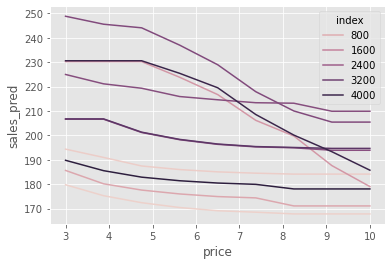

In [29]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=pred_test.query("index in @sample_ids"),
             x="price", y="sales_pred", hue="index");

Il est intéressant de voir que certaines unités sont très sensibles aux augmentations de prix. Dans certains cas, nous prévoyons que les ventes chutent de 250 à presque 200 lorsque nous augmentons le prix de 3 à 10. D'un autre côté, certaines unités sont très inélastiques au prix : en augmentant les prix de 3 à 10, nous prévoyons que les ventes passent d'environ 195 à environ 185.

Il est difficile de voir ces différences de sensibilité aux prix, c'est pourquoi j'aime faire en sorte que toutes les courbes commencent au même point (la moyenne des ventes ici). Cela rendra plus facile de voir que certaines unités connaissent une forte baisse des ventes à mesure que les prix augmentent, tandis que d'autres sont moins affectées.

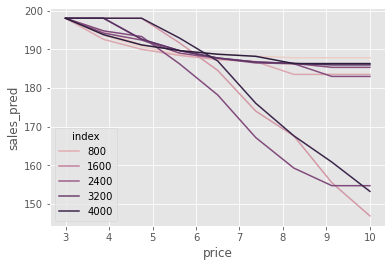

In [30]:
np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

### Plus d'économétrie pourrait être nécessaire !

![img](./data/img/debiased-ml/more-metrics.png)

Je tiens à conclure cette section sur le ML Double/Debiaisé non scientifique avec une mise en garde. Je n'ai pas qualifié cette approche de non scientifique sans raison. C'est en quelque sorte un bricolage pour obtenir des prédictions contrefactuelles non linéaires. Et puisque c'est un bricolage, il est important de parler de ses éventuels inconvénients.

Tout d'abord, elle présente les mêmes problèmes que toutes les techniques de ML lorsqu'elles sont appliquées naïvement à l'inférence causale : le biais. Étant donné que le modèle final est un modèle de ML régularisé, cette régularisation peut biaiser l'estimation causale vers zéro.

Le deuxième problème concerne l'algorithme de ML que vous choisissez. Ici, nous avons choisi des arbres boostés. Les arbres ne sont pas très bons pour faire des prédictions lisses. En conséquence, nous pouvons observer des discontinuités dans la courbe de prédiction. Vous pouvez le voir dans les graphiques ci-dessus : un comportement par étapes par-ci, par-là. De plus, les arbres ne sont pas très performants en matière d'extrapolation, donc ce modèle pourrait produire des prédictions étranges pour des prix jamais observés auparavant.

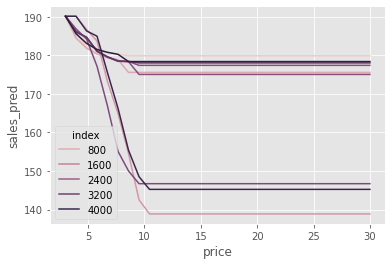

In [31]:
pred_test = (test
             .rename(columns={"price":"factual_price"})
             .assign(jk = 1)
             .reset_index() # create day ID
             .merge(pd.DataFrame(dict(jk=1, price=np.linspace(3, 30, 30))), on="jk")
             .drop(columns=["jk"]))

t_res_test = pred_test[T] - ensamble_pred(pred_test, models_t, X)

y_hat_test = ensamble_pred(pred_test, models_y, X)
pred_test[f"{y}_pred"] = model_final.predict(X=pred_test[X].assign(**{T: t_res_test})) + y_hat_test

np.random.seed(1)
sample_ids = np.random.choice(pred_test["index"].unique(), 10)

sns.lineplot(data=(pred_test
                   .query("index in @sample_ids")
                   .assign(max_sales = lambda d: d.groupby("index")[["sales_pred"]].transform("max"))
                   .assign(sales_pred = lambda d: d["sales_pred"] - d["max_sales"] + d["sales_pred"].mean())),
             x="price", y="sales_pred", hue="index");

Tout cela pour dire que cette approche est fortement dépendante du modèle de ML final. Si vous le régularisez trop, vous biaiserez vos estimations causales vers zéro. Si vous utilisez tel ou tel algorithme de ML, vous emporterez avec vous toutes ses limitations dans vos prédictions contrefactuelles finales. Néanmoins, si vous pensez que cette approche vaut la peine d'être essayée, n'hésitez pas à la tester ! Mais n'oubliez pas les inconvénients que j'ai soulignés ici.

## Idées clés

Le ML Double/Debiaisé/Orthogonal est une méthode qui permet de déléguer l'estimation des paramètres de nuisance, nous permettant ainsi de concentrer notre attention sur le paramètre causal d'intérêt. Il utilise d'abord une procédure d'orthogonalisation en deux étapes :

1. Ajuster un modèle $M_t(X)$ pour prédire le traitement à partir des covariables $X$ et obtenir des résidus hors pli $\tilde{t} = t - M_t(X)$. Nous avons appelé cela le modèle de débiaisage car les résidus $\tilde{t}$ sont, par définition, orthogonaux aux caractéristiques utilisées pour le construire.

2. Ajuster un modèle $M_y(X)$ pour prédire le résultat à partir des covariables $X$ et obtenir des résidus hors pli $\tilde{y} = y - M_y(X)$. Nous avons appelé cela le modèle de débruitage car le résidu $\tilde{y}$ peut être considéré comme une version du résultat où toute la variance due aux caractéristiques a été expliquée.

Une fois que nous avons ces résidus, à condition qu'il n'y ait pas de variables confondantes non mesurées, nous pouvons régresser $\tilde{y}$ sur $\tilde{t}$ pour une approximation linéaire de l'ATE. Nous pouvons également interagir $\tilde{t}$ avec les covariables pour estimer le CATE ou utiliser une astuce de pondération pour permettre à n'importe quel modèle de ML générique de servir de modèle final pour le CATE.

![img](./data/img/debiased-ml/diagram.png)

Enfin, j'ai soutenu que les étapes d'orthogonalisation sont un outil général pour faciliter l'apprentissage causal. Dans cet esprit, nous avons essayé d'introduire les résidus de traitement et de résultat dans un algorithme de ML de type S-learner. Grâce à cela, nous avons réussi à obtenir des prédictions contrefactuelles à partir de traitements simulés. En effet, le ML orthogonal sert de prétraitement dans de nombreuses applications d'inférence causale.

 
## Références

Les choses que j'ai écrites ici viennent principalement de ma propre expérience. Je les ai apprises par la pratique. Cela signifie qu'il n'y a pas de référence directe à laquelle je peux vous renvoyer. Cela signifie aussi que ce que j'ai écrit ici n'a **pas** été soumis à l'examen académique que la bonne science traverse souvent. Au lieu de cela, remarquez comment je parle de choses qui fonctionnent dans la pratique, mais je ne passe pas trop de temps à expliquer pourquoi cela est le cas. C'est une sorte de science de la rue, si vous voulez. Cependant, je mets cela à la disposition du public pour examen, donc, si vous trouvez quelque chose d'absurde, ouvrez un problème et je le traiterai au mieux de mes efforts.
 
Pour écrire ce chapitre, je me suis appuyé sur Chernozhukov et al. (2016), *Double/Debiased Machine Learning for Treatment and Causal Parameters*, D. Foster et V. Syrgkanis (2019) *Orthogonal Statistical Learning* et sur la page de documentation de la bibliothèque *econml*. Le ML orthogonal a suscité beaucoup d'attention récemment, il existe donc de nombreuses autres références sur le sujet. Pour n'en citer que quelques-unes, Nie et Wager (Brouillon, 2020) proposent une discussion intéressante sur la R-loss, Athey et al. (2019) en parlent dans le contexte des arbres de décision causale, et il y a de nombreux articles ultérieurs de Chernozhukov qui développent davantage le sujet.

J'ai également emprunté une image des [diapositives de Pedro Sant'Anna](https://pedrohcgs.github.io/files/Callaway_SantAnna_2020_slides.pdf).

 
## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).